In [1]:
import os
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import random
import sklearn.tree as sktr
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
#Paths to access the necessary data
tree_meta_feature_path = 'C:/Users/Dimiexe/Desktop/DATAsets/DATA/tree_metafeatures_for_test_CSVs'
ground_truth_path = 'C:/Users/Dimiexe/Desktop/DATAsets/DATA/ground_truth'
metaModel_data_path = 'C:/Users/Dimiexe/Desktop/DATAsets/DATA/metaModel_Datasets'
manual_meta_feature_path = 'C:/Users/Dimiexe/Desktop/DATAsets/DATA/manual_metafeatures_for_test_CSVs'

In [2]:
#Combines the extracted metafeatures and ground truth for each dataset into a new dataset.
#Every line contains the 16 metafeatures + 2 (3 for xgboost) ground truth hyperparameters and represents
#a different dataset. Returns that unified dataset.
def build_dataSet_DL(tree_meta_feature_path, ground_truth_path, manual_meta_feature_path = None,
                     algo = 'RF', method = 'drop', eco = True):
    for i,f in enumerate(os.listdir(tree_meta_feature_path + '/' + method)):
        line = pd.read_csv(tree_meta_feature_path + '/' + method + '/' + f,
                           names = ['TreeDiam', 'TreeHeight', 'TotalNodes', 'TotalLeaves',
                                    'maxNodePerLevel', 'meanNodePerLevel', 'stdNodePerLevel',
                                    'ShortBranch', 'meanBranch', 'stdBranch','maxFeatureFreq',
                                    'minFeatureFreq', 'meanFeatureFreq', 'stdFeatureFreq','NaNsPerLine'
                                   ],
                           header = None, sep=',')
        if not manual_meta_feature_path == None:
            line2 = pd.read_csv(manual_meta_feature_path + '/' + method + '/' + f,
                                names = ['nr_inst', 'nr_attr', 'inst_to_attr', 'nr_cat', 'nr_num', 'cat_to_num',
                                         'nr_class_mean', 'nr_class_std', 'cor_mean', 'cor_std', 'cov_mean', 'cov_std',
                                         'kurtosis_mean', 'kurtosis_std', 'mad_mean', 'mad_std', 'max_mean', 'max_std',
                                         'mean_mean', 'mean_std', 'median_mean', 'median_std', 'min_mean', 'min_std',
                                         'std_mean', 'std_std', 'skew_mean', 'skew_std','var_mean', 'var_std'
                                        ],
                                header = None, sep=',')
            line = pd.concat([line, line2], ignore_index = False, axis = 1)
        line2 = pd.read_csv(ground_truth_path + '/' + algo + '/' + f, header = 0, sep=',')
        if algo == 'GLM':
            line2.drop(line2.columns[2:], axis = 1, inplace = True)                
        elif algo == 'RF':
            if eco:
                line2.drop(line2.columns[:3], axis = 1, inplace = True)
            line2.drop(line2.columns[2:], axis = 1, inplace = True)                
        elif algo == 'XGboost':
            if eco:
                line2.drop(line2.columns[:4], axis = 1, inplace = True)
            line2.drop(line2.columns[3:], axis = 1, inplace = True)
        else:
            print("\n>>> Algorithm '" + algo + "' not valid. <<<")
            return None
        line = pd.concat([line, line2], ignore_index = False, axis = 1)
        if i==0:
            df = line
        else:
            df = pd.concat([df, line], ignore_index = True, axis = 0)
    df.to_csv(metaModel_data_path + '/' + algo + '_' + method + '.csv', sep =',', index = False)
    return df

In [3]:
def Data_prep_tree(data, algo):
    if algo in ['RF', 'GLM']:
        y = data.iloc[:, -2:]
        x = data.iloc[:, 0:-2]
    elif algo == 'XGboost':
        y = data.iloc[:, -3:]
        x = data.iloc[:, 0:-3]
    else:
        print('\n>>> Not supported algorithm. Returning None! <<<')
        return None
    return x, y

In [4]:
#Returns "train" and "test" pandas.DataFrames split acording to the provided ratio.
def split_train_test_indices(dataset, split_ratio = .15):
    import random
    rows = dataset.shape[0]
    test_rows = round(rows * split_ratio)
    train_rows = rows - test_rows
    
    #Generate train_data
    train_indices = []
    while len(train_indices) < train_rows:
        candidate = random.randint(0, rows-1)
        if candidate not in train_indices:
            train_indices.append(candidate)
    
    #Generate test data
    test_indices = []
    for j in range(rows):
        if j not in train_indices:
            test_indices.append(j)    
    return train_indices, test_indices

def split_train_test(dataset, split_ratio = .15):
    import random
    rows = len(dataset)
    test_rows = round(rows * split_ratio)
    train_rows = rows - test_rows
    
    #Generate train_data
    train_indices = []
    while len(train_indices) < train_rows:
        candidate = random.randint(0, rows-1)
        if candidate not in train_indices:
            train_indices.append(candidate)
    train = dataset.loc[train_indices,:]
    train.reset_index(drop=True, inplace = True)
    
    #Generate test data
    test_indices = []
    for j in range(rows):
        if j not in train_indices:
            test_indices.append(j)
    test = dataset.loc[test_indices,:]
    test.reset_index(drop=True, inplace = True)    
    return train, test

In [5]:
def fix_preds_calcs(param_vector, single_pred):
    param_vector2 = [abs(x - single_pred) for x in param_vector]
    temp = 0   #Store parameter value
    ind = 100000  #Store parameter comparison value
    for i,pa in enumerate(param_vector2):
        if pa < ind:
            ind = pa
            temp = param_vector[i]
    return temp

def fix_preds(preds, algo, index, lambdas):
    in_preds = []
    length = len(preds)
    if algo == 'GLM':
        if index == 0:
            y = range(0, 1100, 125)
            param_alpha = [x / 1000 for x in y]
            for i in range(length):
                in_preds.append(fix_preds_calcs(param_alpha, preds[i]))
        elif index == 1:
            param_lambda = set(lambdas)
            param_lambda = list(param_lambda)  #Create list of unique train lambda values
            for i in range(length):
                in_preds.append(fix_preds_calcs(param_lambda, preds[i]))
                
    elif algo =='RF':
        if index == 0:
            param_tree = [25,50,75,100,200,300,400,500]
            for i in range(length):
                in_preds.append(fix_preds_calcs(param_tree, preds[i]))
        elif index == 1:
            param_depth = [20,40,60,80]
            for i in range(length):
                in_preds.append(fix_preds_calcs(param_depth, preds[i]))
    elif algo == 'XGboost':
        if index == 0:
            param_tree = [25,50,100,200]
            for i in range(length):
                in_preds.append(fix_preds_calcs(param_tree, preds[i]))
        elif index == 1:
            param_depth = [6,10,15]
            for i in range(length):
                in_preds.append(fix_preds_calcs(param_depth, preds[i]))
        elif index == 2:
            colsample_bytree = [.6,.7,.8,.9]
            for i in range(length):
                in_preds.append(fix_preds_calcs(colsample_bytree, preds[i]))
    return in_preds

In [6]:
def do_cross_val(x_train, y_train, estimator):
    y_cols = len(y_train.columns)
    for target_column in range(y_cols):
        temp =[]
        for i in range(20):
            results = cross_val_score(estimator,
                                      X = x_train,
                                      y = y_train.iloc[:,target_column],
                                      cv = kfold,
                                      scoring = 'neg_root_mean_squared_error'
                                     )
            temp = np.concatenate((temp,results))
        print("%.8f | %.8f | %.8f" % (abs(results.mean()), results.std(), abs(results.mean()) + results.std()))

def do_fit_predict(x_train, y_train, x_test, y_test, estimator, plot_true_preds = False):
    y_cols = len(y_train.columns)
    fig,a =  plt.subplots(1,y_cols,figsize=(20, 5))
    x = range(len(y_test))
    for target_column in range(y_cols):
        estimator.fit(x_train,y_train.iloc[:,target_column])
        y_pred = estimator.predict(x_test)
        #--------------------- Used for rounding to quantized vlues ---------------------#
        if algo == 'GLM' and target_column == 1:                                         #
            y_lambda_values = pd.concat([y_train.iloc[:,1],y_test.iloc[:,1]], axis=0)    #
            preds_fixed = fix_preds(y_pred, algo, target_column, y_lambda_values.values) #
        else:                                                                            #
            preds_fixed = fix_preds(y_pred, algo, target_column, lambdas = None)         #
        #--------------------------------------------------------------------------------#
        #Plotting ground truth
        a[target_column].plot(x,y_test.iloc[:,target_column],'bo')
        #Plotting quantized predictions
        a[target_column].plot(x,preds_fixed,'yx')
        #Plotting true predictions
        if plot_true_preds:
            a[target_column].plot(x,y_pred,'r+')
            a[target_column].legend(['ground truth', 'quantized preds', 'real preds'], loc='upper left')
        else:
            a[target_column].legend(['ground truth', 'quantized preds'], loc='upper left')                        
        print('RMSE for hyperparam "' + y_test.columns[target_column] + '": '+ str(metrics.mean_squared_error(y_test.iloc[:,target_column], preds_fixed, squared = False)))
    plt.show()

In [7]:
#Run this once for each cross validation AND prediction session, as the row
#indices are stored in "train_indices" and "test_indices" and are the same
#for both crossvalidation and fit processes.

manual_indices = True

split_ratio = .15 #Training/Testing set ratio.
kfold = KFold(n_splits=10)
#Creating the dataset once to get its dimensions. We need the number of rows, not columns,
#so any "algo" is aplicable. We dont need the values of the rows, just the rows, so any
#"method" is also aplicable as is the option for eco_best, or absolute_best.
#Also we dont care about the number of metafeatures contained in the dataset, as they
#make up the columns not the rows.
dataset = build_dataSet_DL(tree_meta_feature_path,
                           ground_truth_path,
                           algo = 'RF', method = 'drop', eco = True)
#Get the indices for test and train instances based on extracted dataset dimensions.
if manual_indices:
    train_indices = [28,58,31,29,20,147,157,155,62,159,137,112,118,134,164,90,142,19,60,161,94,18,84,67,56,61,74,30,52,2,117,1,126,65,70,163,73,114,27,139,63,89,154,166,46,6,37,116,8,173,140,13,122,39,135,174,14,36,24,104,124,130,16,141,7,149,167,79,43,69,53,9,77,12,98,22,165,93,85,11,100,108,3,4,145,123,144,10,119,105,129,92,80,33,71,99,107,25,148,97,106,42,109,82,158,51,152,50,168,40,0,146,86,153,41,156,170,136,35,57,143,44,83,102,54,26,177,131,169,120,138,81,68,133,175,132,32,45,78,76,48,59,15,88,113,64,96,171,128,66,75]
    test_indices = [5,17,21,23,34,38,47,49,55,72,87,91,95,101,103,110,111,115,121,125,127,150,151,160,162,172,176]
else:
    train_indices, test_indices = split_train_test_indices(dataset, split_ratio = .15)

------ Algo = GLM ------
NaN method: drop
Meta-features used: 45
RMSE for hyperparam "alpha_best": 0.5181877251716008
RMSE for hyperparam "lambda_best": 144.44321618093304


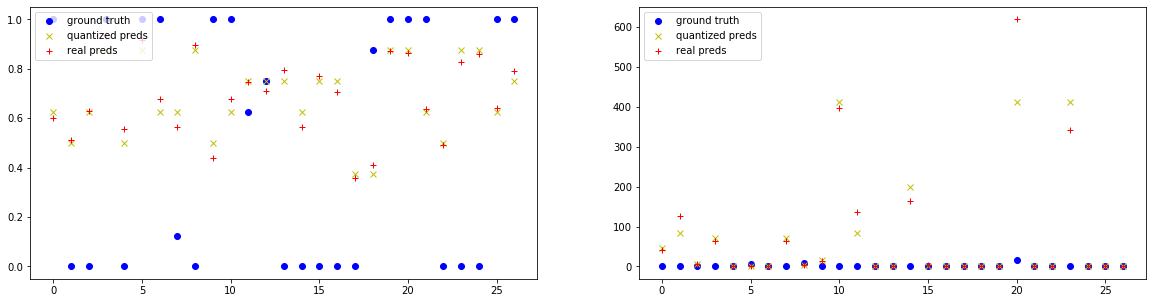

 
------ Algo = RF ------
NaN method: drop
Meta-features used: 45
RMSE for hyperparam "ntrees_eco": 113.6515141415488
RMSE for hyperparam "max_depth_eco": 5.443310539518174


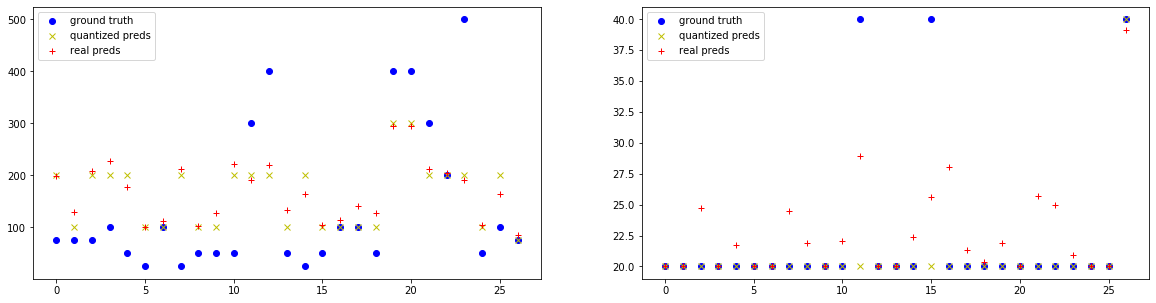

 
------ Algo = XGboost ------
NaN method: drop
Meta-features used: 45
RMSE for hyperparam "ntrees_eco": 50.46083923495819
RMSE for hyperparam "max_depth_eco": 2.449489742783178
RMSE for hyperparam "cols_per_tree_eco": 0.105409255338946


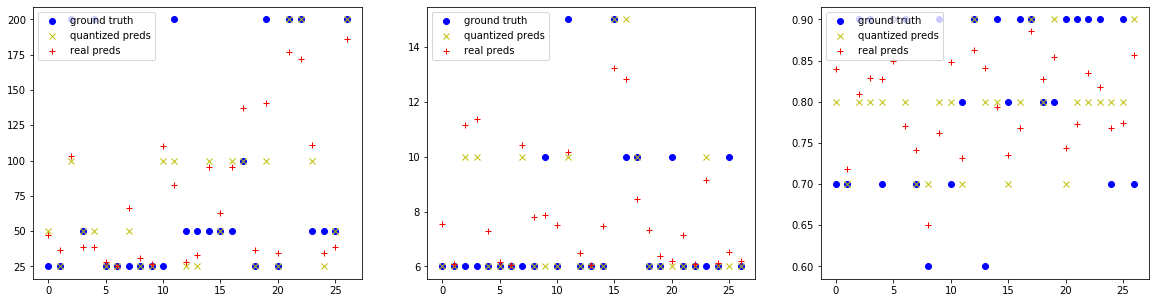

In [8]:
#Fit final models and make predictions.
meta = 'all' #All final models use 45 metafeatures.
eco = True  #All final models use eco forest option.
for algo in ['GLM', 'RF', 'XGboost']:
    print('------ Algo = ' + algo + ' ------')
    if algo == 'XGboost':
        method = 'drop'
    else:
        method = 'drop'
    print('NaN method: ' + method)
    print('Meta-features used: 45')
    if meta == 'all':
        dataset = build_dataSet_DL(tree_meta_feature_path,
                                   ground_truth_path,
                                   manual_meta_feature_path = manual_meta_feature_path,
                                   algo = algo, method = method, eco = eco)            
    elif meta == 'tree':
        dataset = build_dataSet_DL(tree_meta_feature_path,
                                   ground_truth_path,
                                   algo = algo, method = method, eco = eco)
    #Creating train and test datasets according to predefined row indices.
    train = dataset.loc[train_indices,:]
    train.reset_index(drop=True, inplace = True)
    test = dataset.loc[test_indices,:]
    test.reset_index(drop=True, inplace = True)
        
    x_train, y_train = Data_prep_tree(train, algo)
    x_test, y_test = Data_prep_tree(test, algo)
    regr = RandomForestRegressor(random_state = 8328,
                                 min_impurity_decrease = 1e-06,
                                 max_depth = 10,
                                 n_estimators = 1000,
                                 max_features = .8
                                )
    do_fit_predict(x_train = x_train, y_train = y_train,
                   x_test = x_test, y_test = y_test,
                   estimator = regr, plot_true_preds = True
                  )
    print(' ')

In [9]:
#Try different combinations in cv mode to find final models.
#    >>>  DONE  <<<
for meta in ['tree', 'all']:
    for eco in [True, False]:
        if meta == 'tree':
            print('Metafeature set: tree-metafeatures (15)')
        elif meta == 'all':
            print('Metafeature set: tree & manual metafeatures (45)')
        print('Use eco ground truth:', eco)
        print(' ')
        for algo in ['GLM', 'RF', 'XGboost']:
            print('------ Algo = ' + algo + ' ------')    
            for method in ['drop', 'mean', 'median']:
                print('NaN method: ' + method)
                if meta == 'all':
                    dataset = build_dataSet_DL(tree_meta_feature_path,
                                               ground_truth_path,
                                               manual_meta_feature_path = manual_meta_feature_path,
                                               algo = algo, method = method, eco = eco)            
                elif meta == 'tree':
                    dataset = build_dataSet_DL(tree_meta_feature_path,
                                               ground_truth_path,
                                               algo = algo, method = method, eco = eco)
                #Creating train and test datasets according to predefined row indices.
                train = dataset.loc[train_indices,:]
                train.reset_index(drop=True, inplace = True)
                test = dataset.loc[test_indices,:]
                test.reset_index(drop=True, inplace = True)
        
                x_train, y_train = Data_prep_tree(train, algo)
                x_test, y_test = Data_prep_tree(test, algo)
                regr = RandomForestRegressor(random_state = 8328,
                                             min_impurity_decrease = 1e-06,
                                             max_depth = 10,
                                             n_estimators = 1000,
                                             max_features = .8
                                            )
                do_cross_val(x_train = x_train, y_train = y_train, estimator = regr)
            print(' ')

Metafeature set: tree-metafeatures (15)
Use eco ground truth: True
 
------ Algo = GLM ------
NaN method: drop


KeyboardInterrupt: 